In [187]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_all_seq_and_chain_name_and_seq_residues():
    all_H_and_L_chain = np.load("all_H_and_L_chain.npy",allow_pickle=True)
    all_H_and_L_chain = np.squeeze(all_H_and_L_chain)
    
    #获取每条链的名字
    all_chain_name = [ all_H_and_L_chain[i][0] 
                       for i in range(all_H_and_L_chain.shape[0]) ]
    
    #获取每条链上残基的标号（存在“30A 30B”这种情况）
    all_seq_residues = [ sorted(all_H_and_L_chain[i][1]) 
                         for i in range(all_H_and_L_chain.shape[0])]
    
    #获取所有序列（用于比对pssm长度是否与序列长度match）
    all_seq = [ [all_H_and_L_chain[i][1][res_id] for res_id in sorted(all_H_and_L_chain[i][1])] 
                 for i in range(all_H_and_L_chain.shape[0])]
        
    return all_seq, all_chain_name, all_seq_residues

#读取pssm特征
def read_pssm(fname,seq):
    num_pssm_cols = 44
    pssm_col_names = [str(j) for j in range(num_pssm_cols)]
    
    if os.path.exists(fname) == 0:
        print(fname)
        return np.zeros((120,20))
    
    with open(fname,'r') as f:
        tmp_pssm = pd.read_csv(f,delim_whitespace=True,names=pssm_col_names).dropna().values[:,2:22].astype(float)
        
    if tmp_pssm.shape[0] != len(seq):
        raise ValueError('PSSM file is in wrong format or incorrect!')
        
    return tmp_pssm

#读取hhm特征
def read_hhm(fname,seq):
    num_hhm_cols = 22
    hhm_col_names = [str(j) for j in range(num_hhm_cols)]
    
    if os.path.exists(fname) == 0:
        print(fname)
        return np.zeros((120,30))
    
    with open(fname,'r') as f:
        hhm = pd.read_csv(f,delim_whitespace=True,names=hhm_col_names)
    pos1 = (hhm['0']=='HMM').idxmax()+3
    num_cols = len(hhm.columns)
    hhm = hhm[pos1:-1].values[:,:num_hhm_cols].reshape([-1,44])
    hhm[hhm=='*']='9999'
    if hhm.shape[0] != len(seq):
        raise ValueError('HHM file is in wrong format or incorrect!')
        
    return hhm[:,2:-12].astype(float)

#spd33特征预处理
def spd3_feature_sincos(x,seq):
    ASA = x[:,0]
    rnam1_std = "ACDEFGHIKLMNPQRSTVWY-"
    ASA_std = (115, 135, 150, 190, 210, 75, 195, 175, 200, 170,
                        185, 160, 145, 180, 225, 115, 140, 155, 255, 230,1)
    dict_rnam1_ASA = dict(zip(rnam1_std, ASA_std))
    ASA_div =  np.array([dict_rnam1_ASA[i] for i in seq])
    ASA = (ASA/ASA_div)[:,None]
    angles = x[:,1:5]
    HSEa = x[:,5:7]
    HCEprob = x[:,-3:]
    angles = np.deg2rad(angles)
    angles = np.concatenate([np.sin(angles),np.cos(angles)],1)
    return np.concatenate([ASA,angles,HSEa,HCEprob],1)

#读取spd33特征
def read_spd33(fname,seq):
    if os.path.exists(fname) == 0:
        print(fname)
        return np.zeros((120,14))
    
    with open(fname,'r') as f:
        spd3_features = pd.read_csv(f,delim_whitespace=True).values[:,3:].astype(float)
    tmp_spd3 = spd3_feature_sincos(spd3_features,seq)
    if tmp_spd3.shape[0] != len(seq):
        raise ValueError('SPD3 file is in wrong format or incorrect!')
    return tmp_spd3

#获取1D特征
def get1D_feature(all_seq, all_chain_name, all_seq_residues,tag):
    
    all_features = []

    for i in range(277):
        
        #抗体重链
        Heavy_chain_name = all_chain_name[i*2]
        feature_H1 = []
        feature_H2 = []
        feature_H3 = []
        if tag == "pssm":
            features = read_pssm("data/pssm/"+Heavy_chain_name+".pssm",all_seq[i*2])
        elif tag == "hhm":
            features = read_hhm("data/hhm/"+Heavy_chain_name+".hhm",all_seq[i*2])
        else:
            features = read_spd33("data/spd33/"+Heavy_chain_name+".spd33",all_seq[i*2])
        n = 0
        for index in range(len(all_seq_residues[i*2])):

            H_L_index = all_seq_residues[i*2][index][0]

            if( 24 <= H_L_index <= 34):
                feature_H1.append(features[index])

            elif(50<= H_L_index <= 58):
                feature_H2.append(features[index])

            elif(93<= H_L_index <=104):
                feature_H3.append(features[index])

            elif(H_L_index > 104):
                break

        feature_H1 = np.array(feature_H1)
        feature_H2 = np.array(feature_H2)
        feature_H3 = np.array(feature_H3)
        
        #抗体轻链
        Light_chain_name = all_chain_name[i*2+1]
        feature_L1 = []
        feature_L2 = []
        feature_L3 = []
        if tag == "pssm":
            features = read_pssm("data/pssm/"+Light_chain_name+".pssm",all_seq[i*2+1])
        elif tag == "hhm":
            features = read_hhm("data/hhm/"+Light_chain_name+".hhm",all_seq[i*2+1])
        else:
            features = read_spd33("data/spd33/"+Light_chain_name+".spd33",all_seq[i*2+1])
        n = 0
        for index in range(len(all_seq_residues[i*2+1])):

            H_L_index = all_seq_residues[i*2+1][index][0]

            if( 22 <= H_L_index <= 36):
                feature_L1.append(features[index])

            elif(48<= H_L_index <= 58):
                feature_L2.append(features[index])

            elif(87<= H_L_index <=99):
                feature_L3.append(features[index])

            elif(H_L_index > 99):
                break

        feature_L1 = np.array(feature_L1)
        feature_L2 = np.array(feature_L2)
        feature_L3 = np.array(feature_L3)


        all_features.append([Heavy_chain_name+str(1),feature_H1])
        all_features.append([Heavy_chain_name+str(2),feature_H2])
        all_features.append([Heavy_chain_name+str(3),feature_H3])
        all_features.append([Light_chain_name+str(1),feature_L1])
        all_features.append([Light_chain_name+str(2),feature_L2])
        all_features.append([Light_chain_name+str(3),feature_L3])
    
    return all_features

if __name__ == "__main__":
    all_seq, all_chain_name, all_seq_residues = get_all_seq_and_chain_name_and_seq_residues()
    pssm_feature = get1D_feature(all_seq, all_chain_name, all_seq_residues,"pssm")
    pssm_feature = np.save("1Dfeatures/pssm_init_features.npy",pssm_feature)
    hhm_feature = get1D_feature(all_seq, all_chain_name, all_seq_residues,"hhm")
    hhm_feature = np.save("1Dfeatures/hhm_init_features.npy",hhm_feature)
    spd33_feature = get1D_feature(all_seq, all_chain_name, all_seq_residues,"spd33")
    spd33_feature = np.save("1Dfeatures/spd33_init_features.npy",spd33_feature)

In [188]:
import copy

pssm_feature = np.load("1Dfeatures/pssm_init_features.npy",allow_pickle=True)
hhm_feature = np.load("1Dfeatures/hhm_init_features.npy",allow_pickle=True)
spd33_feature = np.load("1Dfeatures/spd33_init_features.npy",allow_pickle=True)

print(len(pssm_feature))
print(len(hhm_feature))
print(len(spd33_feature))

all_pssm_feature = []
all_hhm_feature = []
all_spd33_feature = []

for i in range(len(pssm_feature)):
    pemp_pssm = copy.deepcopy(pssm_feature[i][1])
    all_pssm_feature.append(pemp_pssm)
        
    pemp_hhm = copy.deepcopy(hhm_feature[i][1])
    all_hhm_feature.append(pemp_hhm)
    
    pemp_spd33 = copy.deepcopy(spd33_feature[i][1])
    all_spd33_feature.append(pemp_spd33)


all_pssm_feature = np.array(all_pssm_feature)
all_hhm_feature = np.array(all_hhm_feature)
all_spd33_feature = np.array(all_spd33_feature)

1662
1662
1662


In [189]:
#pssm特征归一化
guiyihua_pssm_feature = copy.deepcopy(all_pssm_feature)
all_pssm_feature_min = np.zeros(20)
all_pssm_feature_max = np.zeros(20)
all_pssm_feature_min[:] = 100000
all_pssm_feature_min

for i in range(all_pssm_feature.shape[0]):
    for j in range(20):
        all_pssm_feature_min[j] = min(all_pssm_feature[i][:,j].min() , all_pssm_feature_min[j])
        all_pssm_feature_max[j] = max(all_pssm_feature[i][:,j].max() , all_pssm_feature_max[j])

print(all_pssm_feature_min)
print(all_pssm_feature_max)

for i in range(all_pssm_feature.shape[0]):
    for j in range(20):
        guiyihua_pssm_feature[i][:,j] = all_pssm_feature[i][:,j] / (all_pssm_feature_max[j] - all_pssm_feature_min[j])

guiyihua_pssm_feature.shape

[ -8.  -8.  -9. -10.  -8.  -7.  -8.  -8.  -7.  -8.  -8.  -8.  -7.  -8.
  -9.  -8.  -8.  -7.  -8.  -8.]
[ 7.  8.  6.  8. 12.  9.  2.  8.  7.  8.  6.  5. 11.  9.  9.  7.  8. 13.
 10.  7.]


(1662,)

In [192]:
#hhm特征归一化
guiyihua_hhm_feature = copy.deepcopy(all_hhm_feature)
all_hhm_feature_min = np.zeros(30)
all_hhm_feature_max = np.zeros(30)
all_hhm_feature_min[:] = 100000
all_hhm_feature_min

for i in range(all_hhm_feature.shape[0]):
    for j in range(30):
        all_hhm_feature_min[j] = min(all_hhm_feature[i][:,j].min() , all_hhm_feature_min[j])
        all_hhm_feature_max[j] = max(all_hhm_feature[i][:,j].max() , all_hhm_feature_max[j])

print(all_hhm_feature_min)
print(all_hhm_feature_max)

for i in range(all_hhm_feature.shape[0]):
    for j in range(30):
        guiyihua_hhm_feature[i][:,j] = all_hhm_feature[i][:,j] / (all_hhm_feature_max[j] - all_hhm_feature_min[j])

guiyihua_hhm_feature.shape

[ 918.  123. 1645. 2458.  980.  502. 2683. 1985. 1820. 1871. 2687. 1302.
 1340. 1916. 2867. 1762. 1818. 1420.  199. 1297.    0. 1046.  278.    0.
   22.    0.    0. 3629.    0.    0.]
[ 9999.  9999. 10176.  9999.  9999.  9999.  9999.  9999.  9999.  9999.
 10026.  9999.  9999.  9999.  9999.  9999.  9999.  9999.  9999.  9999.
  2755. 11576. 11369.  9999.  9999.  9999.  9999. 11734.  8386. 10673.]


(1662,)

In [191]:
#spd33特征归一化
guiyihua_spd33_feature = copy.deepcopy(all_spd33_feature)
all_spd33_feature_min = np.zeros(14)
all_spd33_feature_max = np.zeros(14)
all_spd33_feature_min[:] = 100000
all_spd33_feature_min

for i in range(all_spd33_feature.shape[0]):
    for j in range(14):
        all_spd33_feature_min[j] = min(all_spd33_feature[i][:,j].min() , all_spd33_feature_min[j])
        all_spd33_feature_max[j] = max(all_spd33_feature[i][:,j].max() , all_spd33_feature_max[j])

print(all_spd33_feature_min)
print(all_spd33_feature_max)

for i in range(all_spd33_feature.shape[0]):
    for j in range(14):
        guiyihua_spd33_feature[i][:,j] = all_spd33_feature[i][:,j] / (all_spd33_feature_max[j] - all_spd33_feature_min[j])

guiyihua_spd33_feature.shape

[ 1.77777778e-02 -1.00000000e+00 -9.99975631e-01  6.00420225e-01
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -7.99684658e-01
 -1.00000000e+00  1.30000000e+00  8.60000000e+00  3.00000000e-03
  0.00000000e+00  3.00000000e-03]
[ 0.85172414  1.          1.          0.99961012  1.          0.99992537
  1.          0.          1.         26.4        29.1         0.996
  0.626       0.997     ]


(1662,)

In [193]:
max_length = 101
samples_num = 277

linked_pssm = np.zeros((samples_num,max_length,20))
linked_hhm = np.zeros((samples_num,max_length,30))
linked_spd33 = np.zeros((samples_num,max_length,14))

for i in range(samples_num):
    pemp_pssm = guiyihua_pssm_feature[i*6]
    pemp_hhm = guiyihua_hhm_feature[i*6]
    pemp_spd33 = guiyihua_spd33_feature[i*6]

    for j in range(1,6):
        pemp_pssm = np.append(pemp_pssm,np.zeros((1,20)),axis=0)
        pemp_pssm = np.append(pemp_pssm,guiyihua_pssm_feature[i*6+j],axis=0)
        pemp_hhm = np.append(pemp_hhm,np.zeros((1,30)),axis=0)
        pemp_hhm = np.append(pemp_hhm,guiyihua_hhm_feature[i*6+j],axis=0)
        pemp_spd33 = np.append(pemp_spd33,np.zeros((1,14)),axis=0)
        pemp_spd33 = np.append(pemp_spd33,guiyihua_spd33_feature[i*6+j],axis=0)

        
        
    
    if(pemp_pssm.shape[0] != pemp_hhm.shape[0]):
        print("---------------------------------")

    linked_pssm[i][0:pemp_pssm.shape[0],:] = pemp_pssm
    linked_hhm[i][0:pemp_hhm.shape[0],:] = pemp_hhm
    linked_spd33[i][0:pemp_spd33.shape[0],:] = pemp_spd33

In [194]:
print(linked_pssm.shape)
print(linked_hhm.shape)
print(linked_spd33.shape)

dataset =  {
        "pssm": linked_pssm,
        "hhm": linked_hhm,
        "spd33": linked_spd33,
    }

np.save("train_1Dfeatures_linked.npy",dataset)

(277, 101, 20)
(277, 101, 30)
(277, 101, 14)


In [536]:
a = np.load("all_result_1001_pssm.npy")
b = np.load("all_result_1005_pssm_hhm.npy")
c = np.load("all_result_1001.npy")
d = 2
print(a[0][d])
print(b[0][d])
print(c[0][d])

[0.74335106 0.91358214 0.63494505]
[0.74197861 0.91062083 0.63261204]
[0.73116883 0.9104937  0.61778208]


In [534]:
def get_result(result):
    f_score = []
    auc = []
    mcc =[]
    for i in range(10):
        f_score.append(np.mean(result[i,:,0]))
        auc.append(np.mean(result[i,:,1]))
        mcc.append(np.mean(result[i,:,2]))

    f_score = np.array(f_score)
    auc = np.array(auc)
    mcc = np.array(mcc)
    
    f_score = f_score[f_score.argsort()[-5:][::-1]]
    auc = auc[auc.argsort()[-5:][::-1]]
    mcc = mcc[mcc.argsort()[-5:][::-1]]


    print("f_score: " + str(np.mean(f_score)) + " +/- " + str(2*np.std(f_score)))
    print("auc: " + str(np.mean(auc)) + " +/- " + str(2*np.std(auc)))
    print("mcc: " + str(np.mean(mcc)) + " +/- " + str(2*np.std(mcc)))

In [535]:
np.set_printoptions(suppress=True)

result_CNN_LSTM = np.load("all_result_0923.npy") ## CNN+LSTM
result_LSTM = np.load("all_result_1001.npy") ## LSTM
result_trans_LSTM = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1013_trans_lstm.npy") ## trans LSTM



result_LSTM_pssm = np.load("all_result_1001_pssm.npy") ## pssm LSTM
result_trans_LSTM_pssm = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1014_trans_lstm_pssm.npy") ## trans LSTM



result_trans_LSTM_hhm = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1015_trans_lstm_hhm.npy")

result_trans_LSTM_spd33 = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1015_trans_lstm_spd33.npy")

result_trans_LSTM_all_features = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1016_trans_lstm_all_features.npy")

result_trans_LSTM_all_features_version2 = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1016_trans_lstm_all_features_version2.npy")

result_1016_trans_lstm_pssmhhm = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1016_trans_lstm_pssmhhm.npy")

result_1017_trans_lstm_pssmspd33 = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1017_trans_lstm_pssmspd33.npy")

result_1017_trans_lstm_hhmspd33 = np.load("/home/zpzpzp/antibody/self-attention-seq/all_result_1017_trans_lstm_hhmspd33.npy")



#result3 = np.load("all_result_1005_pssm_hhm.npy") ## pssm hhm LSTM

#result5 = np.load("all_result_1006_pssm_hhm_spd33.npy") ## pssm hhm spd33 LSTM


print("result_CNN_LSTM:")
get_result(result_CNN_LSTM)
print("result_LSTM:")
get_result(result_LSTM)
print("result_trans_LSTM:")
get_result(result_trans_LSTM)

print("#######################################################################")

print("result_LSTM_pssm:")
get_result(result_LSTM_pssm)
print("result_trans_LSTM_pssm:")
get_result(result_trans_LSTM_pssm)

print("#######################################################################")

print("result_trans_LSTM_hhm:")
get_result(result_trans_LSTM_hhm)

print("#######################################################################")

print("result_trans_LSTM_spd33")
get_result(result_trans_LSTM_spd33)

print("#######################################################################")

print("result_trans_LSTM_all_features")
get_result(result_trans_LSTM_all_features)


print("result_trans_LSTM_all_features_version2")
get_result(result_trans_LSTM_all_features_version2)

print("#######################################################################")

print("result_1016_trans_lstm_pssmhhm")
get_result(result_1016_trans_lstm_pssmhhm)

print("#######################################################################")

print("result_1017_trans_lstm_pssmspd33")
get_result(result_1017_trans_lstm_pssmspd33)

print("#######################################################################")

print("result_1017_trans_lstm_hhmspd33")
get_result(result_1017_trans_lstm_hhmspd33)

result_CNN_LSTM:
f_score: 0.6937409723145046 +/- 0.002828887444899523
auc: 0.8882961175239796 +/- 0.0022231917993696666
mcc: 0.5741725824696484 +/- 0.0042666928118724745
result_LSTM:
f_score: 0.6925166884471323 +/- 0.0023039642780845132
auc: 0.8884625058401603 +/- 0.0013199606866729093
mcc: 0.5723164165708703 +/- 0.0033580455451659498
result_trans_LSTM:
f_score: 0.7018100122405211 +/- 0.00228717771915857
auc: 0.8887723240076489 +/- 0.0012358797060767054
mcc: 0.5849106757365008 +/- 0.0032020374497147403
#######################################################################
result_LSTM_pssm:
f_score: 0.7032384620211409 +/- 0.004657279090860252
auc: 0.895220524710866 +/- 0.0012752372580242092
mcc: 0.5880321015447716 +/- 0.006437025075844287
result_trans_LSTM_pssm:
f_score: 0.7106821891927808 +/- 0.0033371281093568794
auc: 0.8943926356793044 +/- 0.0011239933457270154
mcc: 0.5976599462777651 +/- 0.004745341686119895
#######################################################################
re

In [410]:
all_fold_result = np.load("/home/zpzpzp/antibody/self-attention-seq/all_fold_result_1013_trans_lstm.npy")
all_fold_result_hhm = np.load("/home/zpzpzp/antibody/self-attention-seq/all_fold_result_1015_trans_lstm_hhm.npy")
all_fold_result_pssm = np.load("/home/zpzpzp/antibody/self-attention-seq/all_fold_result_1014_trans_lstm_pssm.npy")

print("all_fold_result:")
print(all_fold_result)
print("#######################################################################")
print("all_fold_result_pssm:")
print(all_fold_result_pssm)
print("#######################################################################")
print("all_fold_result_hhm:")
print(all_fold_result_hhm)

all_fold_result:
[[[0.69510099 0.8876917  0.57482216]]

 [[0.6960597  0.88967697 0.57588969]]

 [[0.69266033 0.88822122 0.57088812]]

 [[0.69463344 0.8880666  0.57368029]]

 [[0.69228274 0.88861146 0.57129023]]

 [[0.69537365 0.88928538 0.57544609]]

 [[0.69391932 0.88698477 0.57274571]]

 [[0.689133   0.88714661 0.56659806]]

 [[0.69458519 0.88787626 0.57359742]]

 [[0.69578288 0.88773485 0.57611198]]]
#######################################################################
all_fold_result_pssm:
[[[0.70319694 0.89324426 0.58659251]]

 [[0.7022028  0.8913727  0.58451664]]

 [[0.70165613 0.89389584 0.58448423]]

 [[0.70550292 0.89498417 0.58991443]]

 [[0.70518539 0.89459988 0.58890615]]

 [[0.70220916 0.89491019 0.5855812 ]]

 [[0.70660178 0.89357309 0.59122699]]

 [[0.69930403 0.89210524 0.58070178]]

 [[0.69924281 0.89336624 0.58098753]]

 [[0.69813639 0.88997496 0.57868855]]]
#######################################################################
all_fold_result_hhm:
[[[0.69828557 0.

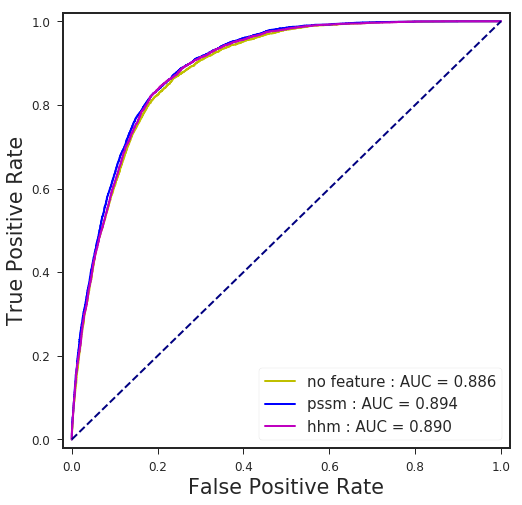

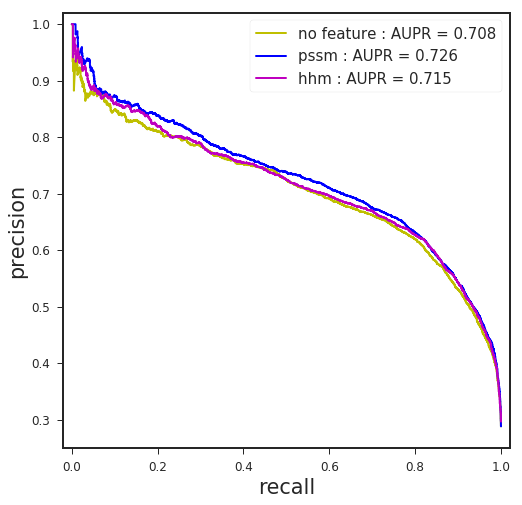